# Fitting gammapy spectra with sherpa

Once we have exported the spectral files (PHA, ARF, RMF and BKG) in the OGIP format, it becomes possible to fit them later with gammapy or with any existing OGIP compliant tool such as XSpec or sherpa.

We show here how to do so with sherpa using the high-level user interface. For a general view on how to use stand-alone sherpa, see this [tutorial](http://nbviewer.jupyter.org/github/sherpa/sherpa/blob/master/docs/SherpaQuickStart.ipynb)

## Load data stack

We first need to import the user interface and load the data with [load_data](http://cxc.harvard.edu/sherpa/ahelp/load_data.html). One can load files one by one, or more simply load them all at once through a [DataStack](http://cxc.harvard.edu/sherpa/ahelp/datastack.html).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import glob   # to list files
from os.path import expandvars
from sherpa.astro.datastack import DataStack
import sherpa.astro.datastack as sh

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
import sherpa
print('sherpa:', sherpa.__version__)

sherpa: 4.10.0


In [3]:
ds = DataStack()
ANALYSIS_DIR = expandvars('$GAMMAPY_EXTRA/datasets/hess-crab4_pha/')
filenames = glob.glob(ANALYSIS_DIR + 'pha_obs*.fits')
for filename in filenames:
    sh.load_data(ds, filename)
    
# see what is stored
ds.show_stack()

read ARF file /Users/deil/work/code/gammapy-extra/datasets/hess-crab4_pha/arf_obs23523.fits
read RMF file /Users/deil/work/code/gammapy-extra/datasets/hess-crab4_pha/rmf_obs23523.fits
read background file /Users/deil/work/code/gammapy-extra/datasets/hess-crab4_pha/bkg_obs23523.fits
read ARF file /Users/deil/work/code/gammapy-extra/datasets/hess-crab4_pha/arf_obs23592.fits
read RMF file /Users/deil/work/code/gammapy-extra/datasets/hess-crab4_pha/rmf_obs23592.fits
read background file /Users/deil/work/code/gammapy-extra/datasets/hess-crab4_pha/bkg_obs23592.fits
1: /Users/deil/work/code/gammapy-extra/datasets/hess-crab4_pha/pha_obs23523.fits OBS_ID: 23523 MJD_OBS: N/A
2: /Users/deil/work/code/gammapy-extra/datasets/hess-crab4_pha/pha_obs23592.fits OBS_ID: 23592 MJD_OBS: N/A


## Define source model

We can now use sherpa models. We need to remember that they were designed for X-ray astronomy and energy is written in keV. 

Here we start with a simple PL.

In [4]:
# Define the source model
ds.set_source("powlaw1d.p1")

# Change reference energy of the model 
p1.ref = 1e9   # 1 TeV = 1e9 keV
p1.gamma = 2.0
p1.ampl = 1e-20  # in cm**-2 s**-1 keV**-1

# View parameters 
print(p1)

powlaw1d.p1
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   p1.gamma     thawed            2          -10           10           
   p1.ref       frozen        1e+09 -3.40282e+38  3.40282e+38           
   p1.ampl      thawed        1e-20            0  3.40282e+38           


## Fit and error estimation

We need to set the correct statistic: [WSTAT](http://cxc.harvard.edu/sherpa/ahelp/wstat.html). We use functions [set_stat](http://cxc.harvard.edu/sherpa/ahelp/set_stat.html) to define the fit statistic, [notice](http://cxc.harvard.edu/sherpa/ahelp/notice.html) to set the energy range, and [fit](http://cxc.harvard.edu/sherpa/ahelp/fit.html)

In [5]:
### Define the statistic
sh.set_stat("wstat")

### Define the fit range
ds.notice(0.6e9, 20e9)

### Do the fit
ds.fit()

Datasets              = 1, 2
Method                = levmar
Statistic             = wstat
Initial fit statistic = 199.265
Final fit statistic   = 83.0206 at function evaluation 199
Data points           = 56
Degrees of freedom    = 54
Probability [Q-value] = 0.00677453
Reduced statistic     = 1.53742
Change in statistic   = 116.245
   p1.gamma       2.11213     
   p1.ampl        2.19357e-20 


## Results plot

Note that sherpa does not provide flux points. It also only provides plot for each individual spectrum.

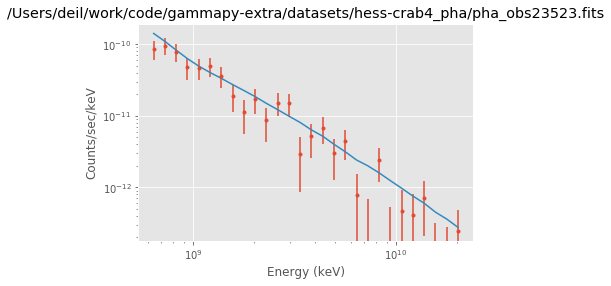

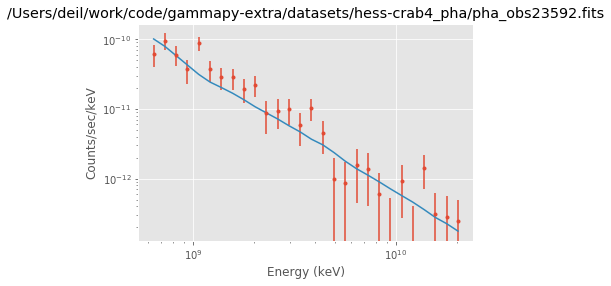

In [6]:
sh.get_data_plot_prefs()["xlog"] = True
sh.get_data_plot_prefs()["ylog"] = True
ds.plot_fit()

## Errors and confidence contours

We use [conf](http://cxc.harvard.edu/sherpa/ahelp/conf.html) and [reg_proj](http://cxc.harvard.edu/sherpa/ahelp/reg_proj.html) functions.

In [7]:
# Compute confidence intervals
ds.conf()

p1.gamma lower bound:	-0.0677549
p1.ampl lower bound:	-1.52537e-21
p1.gamma upper bound:	0.069005
p1.ampl upper bound:	1.59859e-21
Datasets              = 1, 2
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = wstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   p1.gamma          2.11213   -0.0677549     0.069005
   p1.ampl       2.19357e-20 -1.52537e-21  1.59859e-21


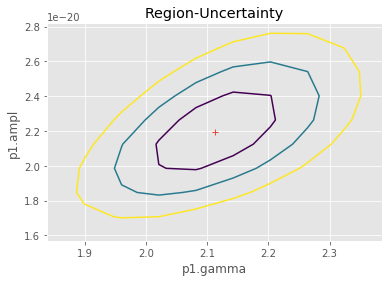

In [8]:
# Compute confidence contours for amplitude and index
sh.reg_unc(p1.gamma, p1.ampl)

## Exercises

- Change the energy range of the fit to be only 2 to 10 TeV
- Fit the built-in Sherpa exponential cutoff powerlaw model
- Define your own spectral model class (e.g. powerlaw again to practice) and fit it